In [1]:
%cd /home/aditya/Documents/SolarCycleProject/code
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import gaussian
import src.preprocesser as pre
import src.network as network
import src.plotter as plotter 
from src.hyperparams import *

# import tf.keras
%load_ext autoreload
%matplotlib notebook
%load_ext tensorboard

/home/aditya/Documents/SolarCycleProject/code


In [2]:
%autoreload

In [3]:
# Getting the data
headers = ["Year",
           "Month",
           "Day",
           "Decimal Date",
           "Daily Total Sunspot Number",
           "Sunspot Number Stddev",
           "No of observations",
           "Definitive/Provisional"
]
filename = "data/SN_d_tot_V2.0.csv"
data = pd.read_csv(filename, delimiter=";", names=headers)[:1000]

In [4]:
data

,Year,Month,Day,Decimal Date,Daily Total Sunspot Number,Sunspot Number Stddev,No of observations,Definitive/Provisional
0,1818,1,1,1818.001,-1,-1.0,0,1
1,1818,1,2,1818.004,-1,-1.0,0,1
2,1818,1,3,1818.007,-1,-1.0,0,1
3,1818,1,4,1818.010,-1,-1.0,0,1
4,1818,1,5,1818.012,-1,-1.0,0,1
...,...,...,...,...,...,...,...,...
995,1820,9,22,1820.725,-1,-1.0,0,1
996,1820,9,23,1820.728,25,6.3,1,1
997,1820,9,24,1820.731,-1,-1.0,0,1
998,1820,9,25,1820.734,0,2.0,1,1


In [5]:
# Data Preprocessing
dates, spots, inverter = pre.preprocess(data)

ymax: 202.0 ymin: 0.0
x.shape: (993,)
y.shape: (993,)
y values scaler: 202.0


In [6]:
if mean_type == "gaussian":
    weights = gaussian(M=mean_length, std=0.1, sym=True)
    weights /= np.sum(weights) # normalise the weights
    spots = pre.running_mean_helper(spots, weights)
elif mean_type == "uniform":
    weights = np.ones(mean_length)/mean_length
    spots = pre.running_mean_helper(spots, weights)
else:
    pass


In [7]:
X = np.diff(spots)
index = dates[1:]
x_slid, y_slid, idx_slid = pre.sliding_window_main(X, X, index=index, predict_ahead=predict_ahead)
x_train, y_train, idx_train, x_val, y_val, idx_val, x_test, y_test, idx_test = pre.data_splitting_main(x_slid, y_slid, idx_slid)

x_slid.shape: (977, 10, 1)
y_slid.shape: (977, 1)
x_train.shape:  (576, 10, 1)
y_train.shape:  (576, 1)
idx_train.shape:  (576,)
x_val.shape:  (192, 10, 1)
y_val.shape:  (192, 1)
idx_val.shape:  (192,)
x_test.shape:  (192, 10, 1)
y_test.shape:  (192, 1)
idx_test.shape:  (192,)



In [8]:
net = network.create_network()

In [9]:
history = network.trainer(net, x_train, y_train, x_val, y_val, verbose=2)
# net.load_weights("models/run_200515_1236.hdf5")
var_train = np.var(y_train)
var_val = np.var(y_val)
print("Variance in y_train:", var_train)
print("Variance in y_val:", var_val)

Train on 576 samples, validate on 192 samples
Epoch 1/100
576/576 - 5s - loss: 0.0077 - val_loss: 0.0061
Epoch 2/100
576/576 - 0s - loss: 0.0077 - val_loss: 0.0061
Epoch 3/100
576/576 - 0s - loss: 0.0077 - val_loss: 0.0061
Epoch 4/100
576/576 - 0s - loss: 0.0077 - val_loss: 0.0061
Epoch 5/100
576/576 - 0s - loss: 0.0077 - val_loss: 0.0061
Epoch 6/100
576/576 - 1s - loss: 0.0077 - val_loss: 0.0061
Epoch 7/100
576/576 - 0s - loss: 0.0077 - val_loss: 0.0061
Epoch 8/100
576/576 - 1s - loss: 0.0077 - val_loss: 0.0061
Epoch 9/100
576/576 - 0s - loss: 0.0077 - val_loss: 0.0061
Epoch 10/100
576/576 - 0s - loss: 0.0077 - val_loss: 0.0061
Epoch 11/100
576/576 - 0s - loss: 0.0077 - val_loss: 0.0061
Epoch 12/100
576/576 - 0s - loss: 0.0077 - val_loss: 0.0061
Epoch 13/100
576/576 - 0s - loss: 0.0077 - val_loss: 0.0061
Epoch 14/100
576/576 - 0s - loss: 0.0077 - val_loss: 0.0061
Epoch 15/100
576/576 - 0s - loss: 0.0077 - val_loss: 0.0061
Epoch 16/100
576/576 - 0s - loss: 0.0077 - val_loss: 0.0061
Epo

<IPython.core.display.Javascript object>


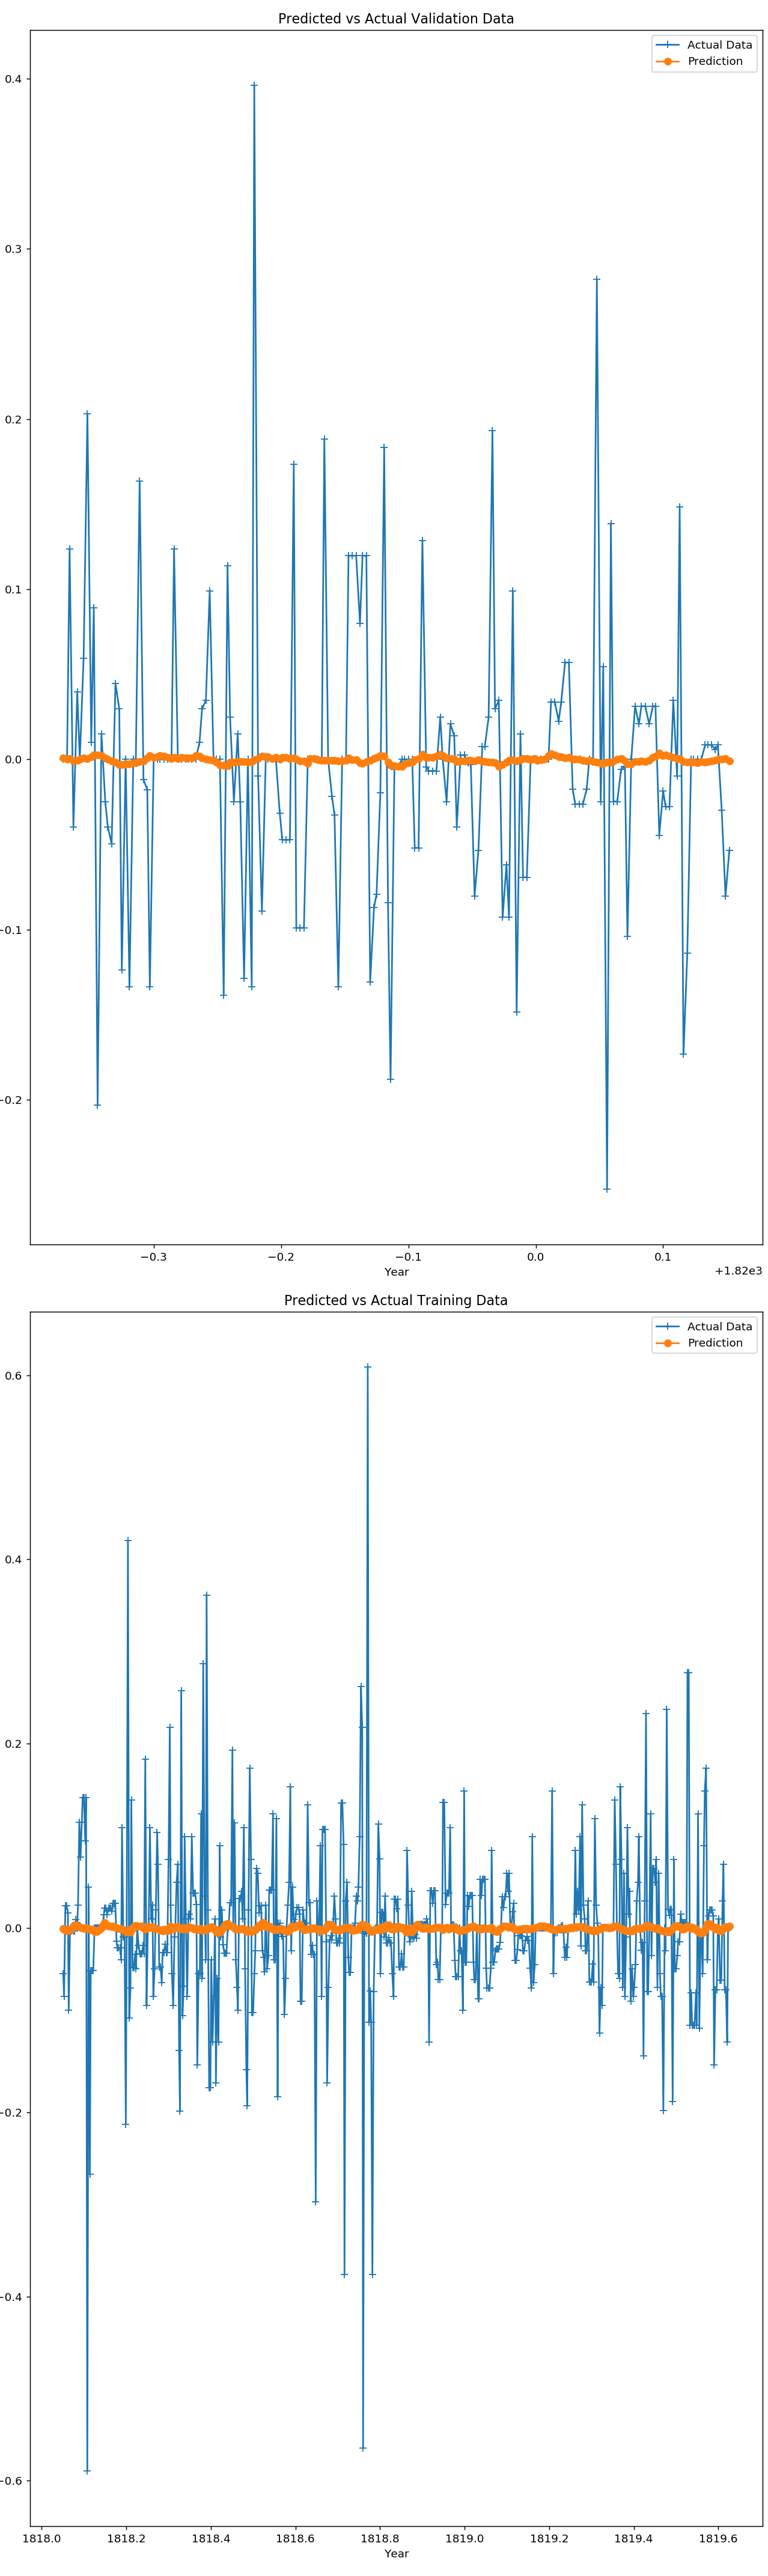

pred1.shape: (192, 1)
pred2.shape: (576, 1)


<IPython.core.display.Javascript object>


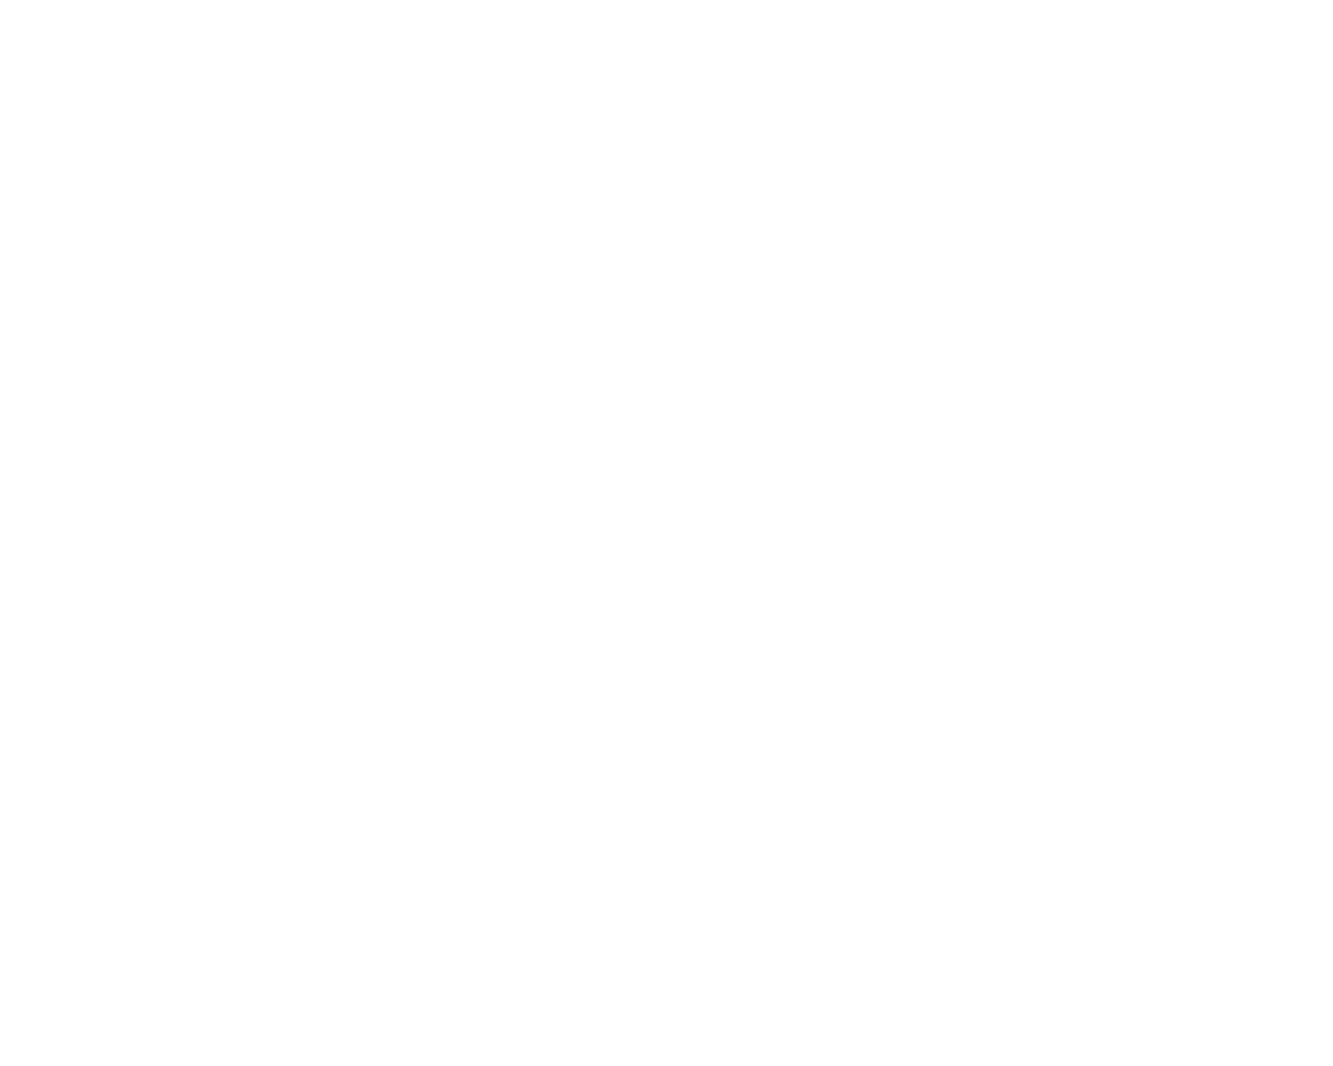

In [10]:
plotter.plot_predictions(net, x_train, y_train, idx_train, x_val, y_val, idx_val)
plotter.plot_loss_vs_epoch(history, var_train, var_val)

cols: [3, 3, 2]


<IPython.core.display.Javascript object>


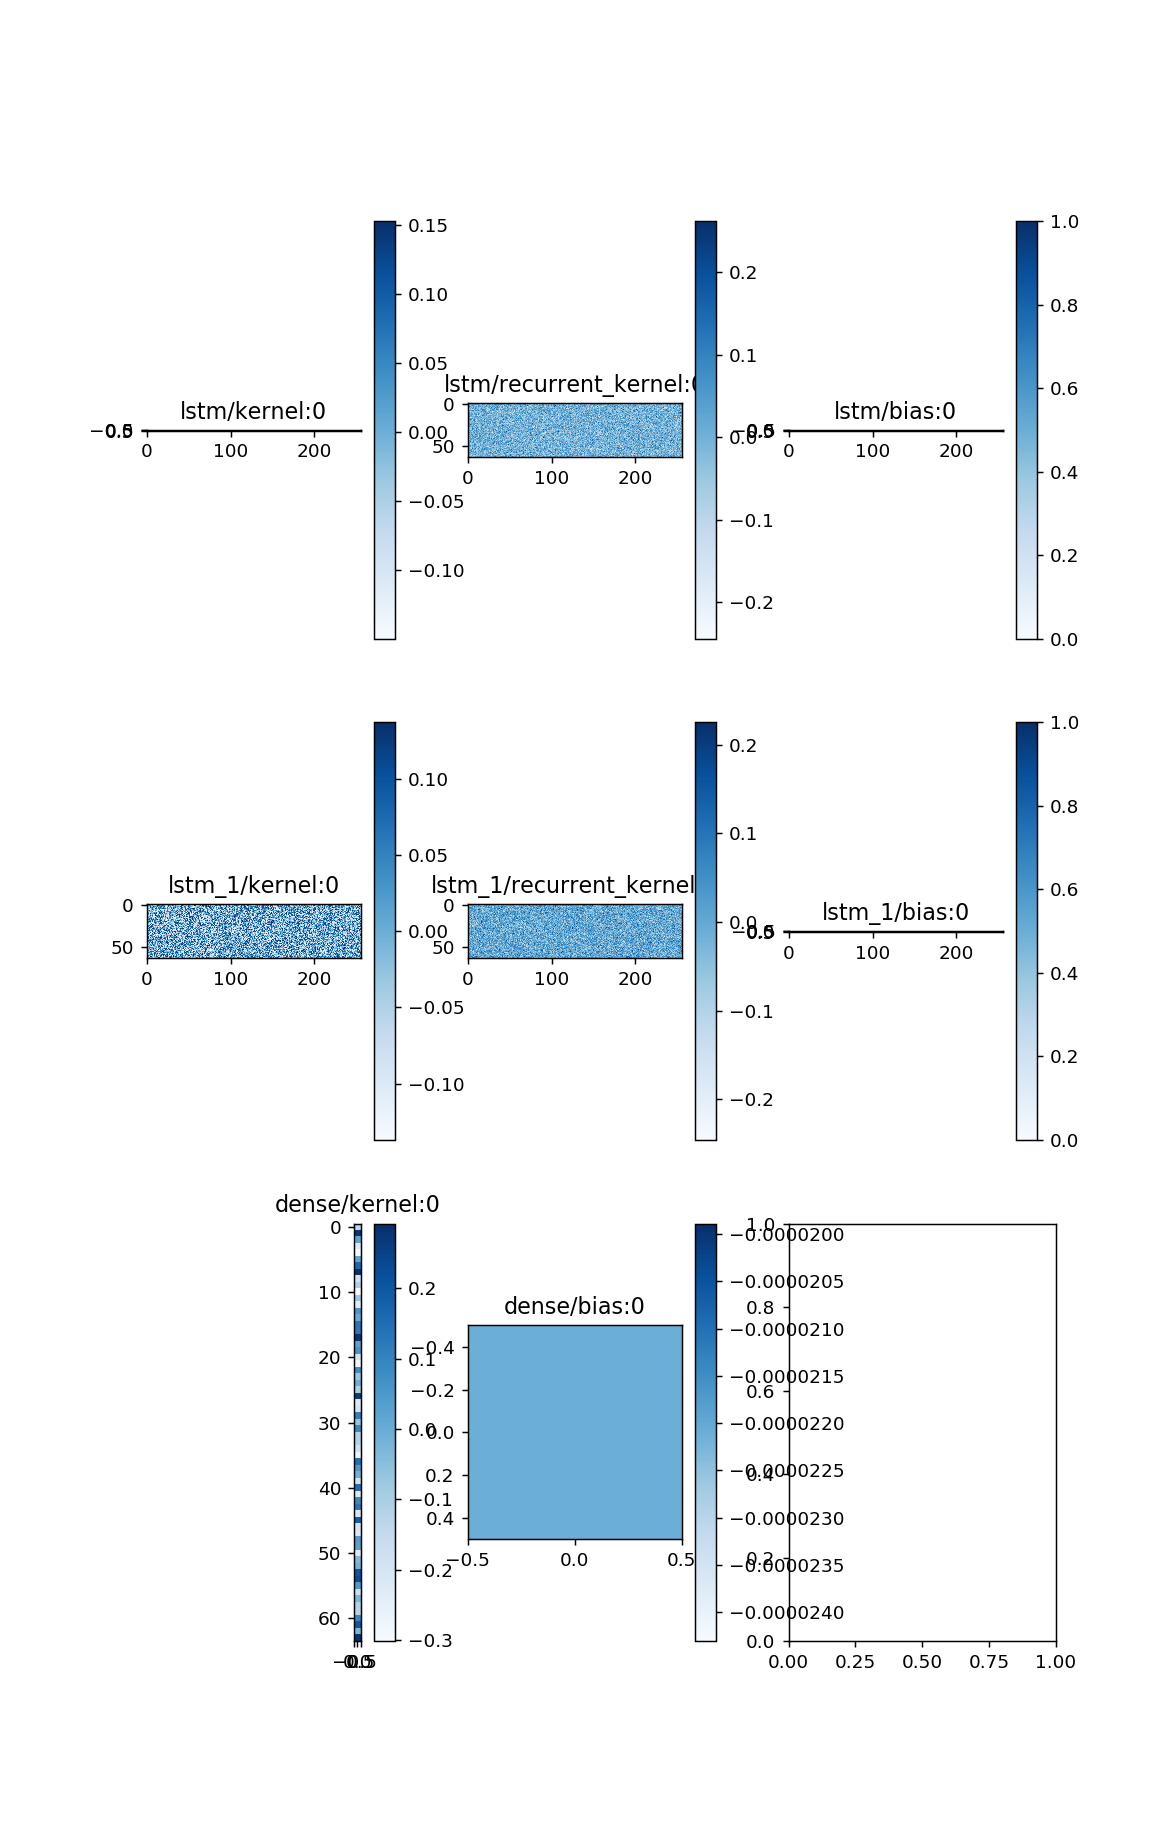

In [11]:
plotter.plot_weights(net)

In [12]:
predictor = network.create_network(predictor=True)
predictor.set_weights(net.get_weights())

idx_step = np.average(np.diff(idx_slid))
x_start = x_train[:batch_size, :, :]
idx_start = idx_train[:batch_size]
idx_end = idx_train[-1]
args = (
    predictor,
    x_start,
    idx_start,
    idx_end,
    idx_step
)
predictor.reset_states()
# net.reset_states()
npred = predictor.predict(x_train, batch_size=1)
rpred, idx_rpred = network.predict_from_self(*args)
# loss_func = keras.losses.MeanSquaredError()
# print("Loss: %.4f" % loss_func(y_train, rpred))

Going to enter the loop now.
num_iters: 577
timesteps: 10
Out of the loop now.


<IPython.core.display.Javascript object>


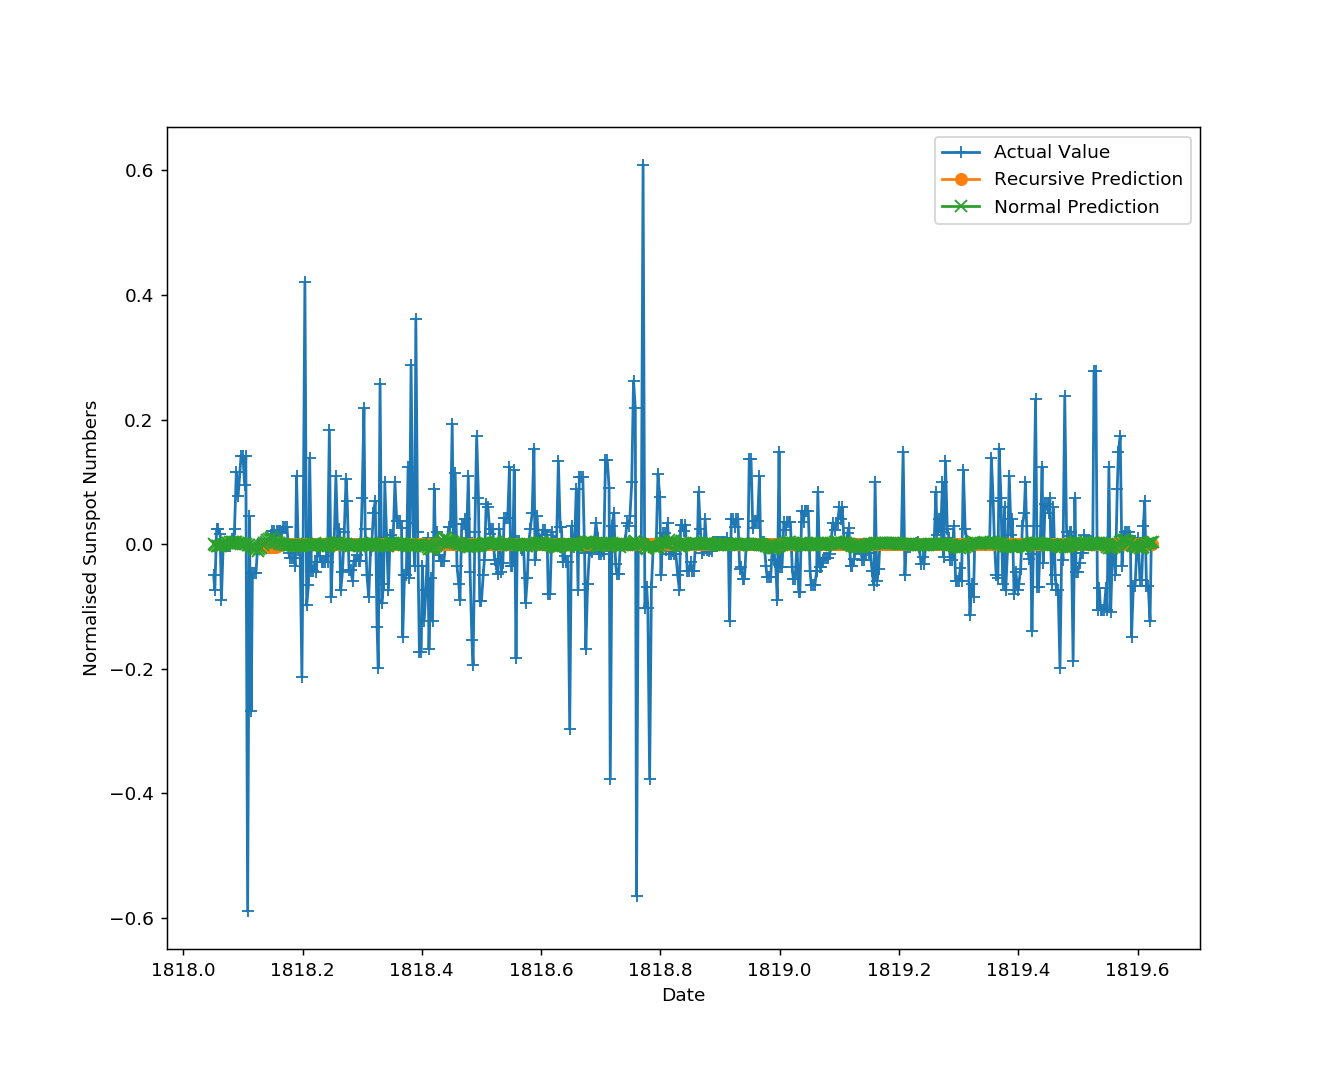

In [23]:
plt.figure(figsize=(10,8))
plt.plot(idx_train, y_train, label="Actual Value", marker="+")
plt.plot(idx_rpred, rpred, label="Recursive Prediction", marker="o")
# plt.plot(x_start[:, 1], marker="s")
# plt.plot(predictor.predict(x_start, batch_size=1), marker=".")
plt.plot(idx_train, npred, label="Normal Prediction", marker="x")

plt.xlabel("Date")
plt.ylabel("Normalised Sunspot Numbers")
plt.legend()

0.08797036751623655


<IPython.core.display.Javascript object>


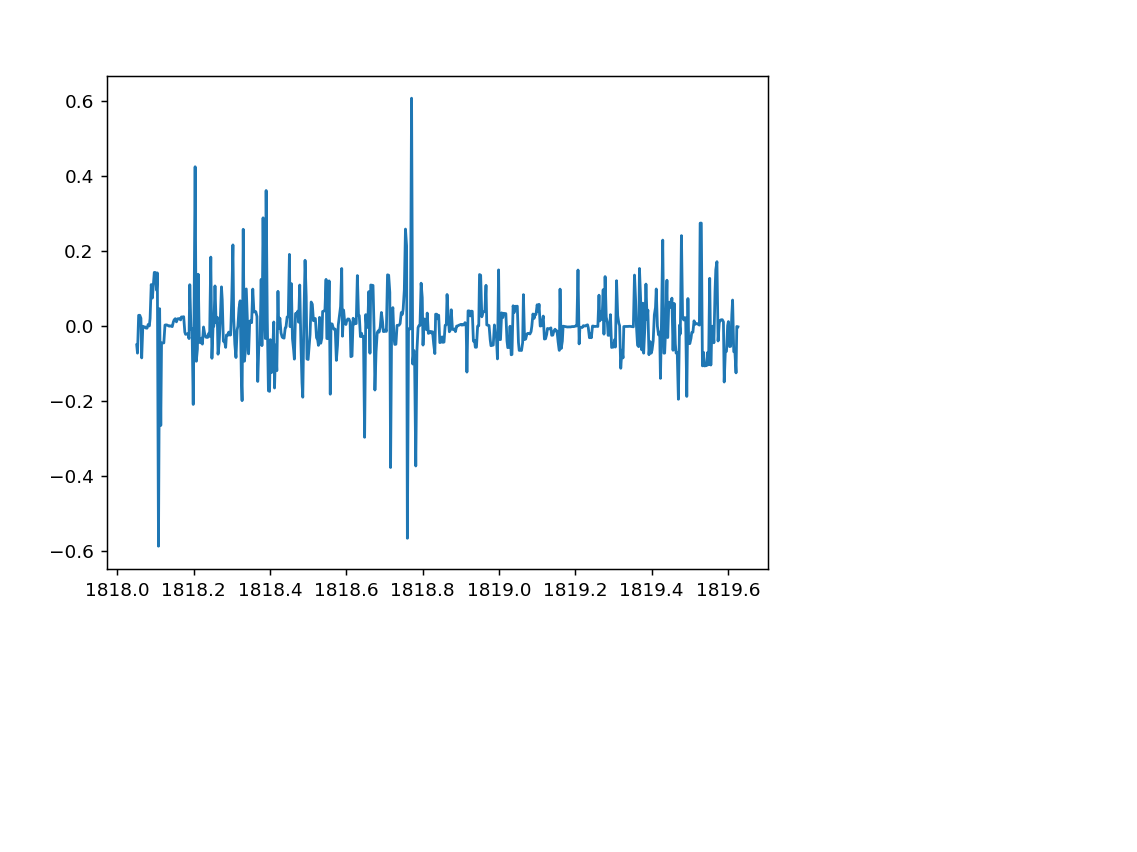

In [24]:
diff_train = y_train - net.predict(x_train)
print(np.std(diff_train))
plt.figure()
plt.plot(idx_train, diff_train)

0.08799054835051971


<IPython.core.display.Javascript object>


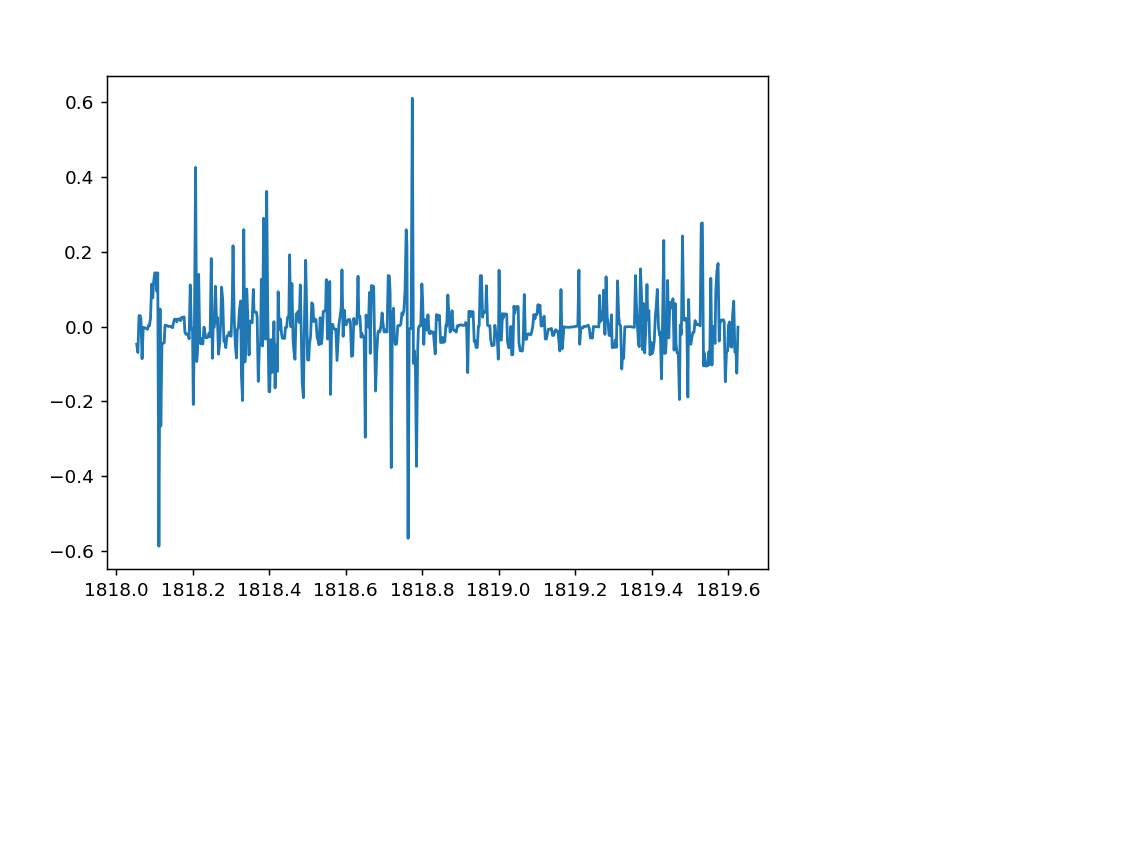

In [25]:
diff_train_shift = y_train[:-1] - net.predict(x_train)[1:]
print(np.std(diff_train_shift))
plt.figure()
plt.plot(idx_train[1:], diff_train_shift)

In [16]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 1888), started 0:04:51 ago. (Use '!kill 1888' to kill it.)

/bin/sh: 1: kill: No such process

